In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/MyDrive/Colab Notebooks/term_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/Colab Notebooks/term_project


In [ ]:
# 최초 1회만 실행

import tarfile

data_root = 'dataset'
tar = tarfile.open("dataset/cifar-10-python.tar.gz")
tar.extractall(data_root)
tar.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Data load

In [ ]:
from data_utils import load_CIFAR10

cifar10_dir = 'dataset/cifar-10-batches-py'

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

### Data preprocessing

In [ ]:
X_train = X_train.reshape(len(X_train.squeeze()), -1)
X_test = X_test.reshape(len(X_test.squeeze()), -1)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


### model

In [ ]:
# Linear Layer
class Linear :
    def __init__(self, input_size=1, hidden_size=1) :
        self.W = np.random.randn(input_size, hidden_size) # input_size와 hidden_size를 가지는 정규분포를 따르는 난수 생성
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x) :
        self.x = x
        out = np.dot(x, self.W) + self.b  # 입력값(x) * 가중치(W) + Bias(b)
        return out

    def backward(self, dout, lr) :
        dx = np.dot(dout, self.W.T) # 입력값에 대한 미분값
        self.dW = np.dot(self.x.T, dout)  # 가중치에 대한 미분값

        self.db = np.sum(dout, axis=0)  # Bias에 대한 미분값
        self.W -= lr * self.dW  # 학습률(lr)을 통해 가중치 업데이트
        self.b -= lr * self.db  # 학습률(lr)을 통해 Bias 업데이트
        return dx

In [ ]:
# Softmax & Cross Entropy
class Softmax_with_CrossEntropy :
    def __init__(self) :
        # softmax
        self.softmax_x = None
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        self.delta = 1e-7

    def softmax_forward(self, x) :
        self.softmax_x = x
        tmp = np.max(self.softmax_x, axis=1).reshape(-1, 1)
        self.softmax_out = np.exp(self.softmax_x-tmp)/np.sum(np.exp(self.softmax_x-tmp), axis=1).reshape(-1,1)
        return self.softmax_out

    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        loss = -np.sum(self.target*np.log(self.pred+self.delta), axis=1)
        return loss

    def backward(self) :
        dout = (self.pred-self.target)/len(self.pred)
        return dout

In [ ]:
# One Hot Label
def make_one_hot(labels) :
    a = []
    for label in labels :
        one_hot = np.zeros(10)
        one_hot[label] = 1
        a.append(one_hot)
    a = np.array(a)
    return a

In [ ]:
def power_iteration(X, num_iter, epsilon = 1e-10) :

    X_centered = X - np.mean(X, axis=0)   # Data centered
    A = np.cov(X_centered, rowvar=False)  # Construct covariance matrix

    M, N = X.shape
    convert_matrix = np.zeros((N, num_iter))  # Initializing conversion matrix

    for k in range(num_iter) :    # Power iteration
      b = np.ones(N) / np.sqrt(N) # eigen vector
      while True :
        b_next = np.dot(A, b) / np.linalg.norm(np.dot(A, b))

        if np.linalg.norm(b_next - b) < epsilon :
          break

        b = b_next

      eigen_value = np.dot(b_next, np.dot(A, b_next)) # Compute eigen value
      A -= eigen_value * np.outer(b_next, b_next)     # Update A

      convert_matrix[:, k] = b_next # Save the eigen vector in Convert matrix

    return convert_matrix

In [ ]:
class L2_regularization :
    def __init__(self, lamb) :
        self.lamb = lamb

    def forward(self, W) :
        self.W = W
        self.regularization_term = 0.5 * self.lamb * np.sum(self.W**2)
        return self.regularization_term

    def backward(self, W) :
        return self.lamb * W

In [ ]:
class Relu :
    def __init__(self) :
        self.mask =None

    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout) :
        dout[self.mask] = 0
        return dout

In [ ]:
class Leaky_Relu :
    def __init__(self) :
        self.mask = None

    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] *= 0.01
        return out

    def backward(self, dout) :
        dout[self.mask] *= 0.01
        return dout

### Train

In [ ]:
from collections import OrderedDict

def train(X, num_epoch, lr, A, M, N, batch_size, L2, L2_bool = True) :
      chart = []

      layer1 = Linear(A, M)
      relu1 = Relu()
      layer2 = Linear(M, N)
      relu2 = Leaky_Relu()
      layer3 = Linear(N, 10)
      softmax_layer = Softmax_with_CrossEntropy()

      L2_reg = L2_regularization(L2)

      for iter in range(num_epoch) :
          if L2_bool == True :
              indices = np.random.choice(len(X), batch_size, replace = False)
              x = layer1.forward(X[indices])
          else :
              x = layer1.forward(X)

          x = relu1.forward(x)
          x = layer2.forward(x)
          x = relu2.forward(x)
          x = layer3.forward(x)
          preds = softmax_layer.softmax_forward(x)

          if L2_bool == True :
              one_hot_labels = make_one_hot(y_train[indices])
          else :
              one_hot_labels = make_one_hot(y_train)

          losses = softmax_layer.crossEntropy_forward(preds, one_hot_labels)
          loss = losses.sum() / len(preds)

          chart.append(loss)

          dL = softmax_layer.backward()
          dL = layer3.backward(dL, lr)
          dL = relu2.backward(dL)
          dL = layer2.backward(dL, lr)
          dL = relu1.backward(dL)
          dL = layer1.backward(dL, lr)

          if L2_bool == True :
              layer1.W -= lr * L2_reg.backward(layer1.W)
              layer2.W -= lr * L2_reg.backward(layer2.W)
              layer3.W -= lr * L2_reg.backward(layer3.W)

          if iter == 0 or (iter+1) % (num_epoch/10) == 0 :
              print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))

      model = OrderedDict()
      model['layer1'] = layer1
      model['relu1'] = relu1
      model['layer2'] = layer2
      model['relu2'] = relu2
      model['layer3'] = layer3
      model['softmax_layer'] = softmax_layer

      return model, chart

### Model

In [ ]:
def model(X):
    A = 20
    M = 1024
    N = 512
    batch_size = 1000
    num_epoch = 18000
    lr = 0.0015
    L2 = 0.1
    L2_bool = True

    X_processed = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    convert_matrix = power_iteration(X_processed, A)
    X_pca = np.dot(X_processed, convert_matrix)

    model, chart = train(X_pca, num_epoch, lr, A, M, N, batch_size, L2, L2_bool)

    X_test_processed = (X - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    X_test_pca = np.dot(X_test_processed, convert_matrix)

    layer1 = model['layer1']
    relu1 = model['relu1']
    layer2 = model['layer2']
    relu2 = model['relu2']
    layer3 = model['layer3']
    softmax_layer = model['softmax_layer']

    x = layer1.forward(X_test_pca)
    x = relu1.forward(x)
    x = layer2.forward(x)
    x = relu2.forward(x)
    x = layer3.forward(x)
    preds = softmax_layer.softmax_forward(x)

    import matplotlib as mpl
    import matplotlib.pylab as plt

    y = chart
    x = [i for i in range(num_epoch)]
    plt.plot(x, y)
    plt.ylabel('Loss')
    plt.xlabel('Trial')

    plt.show()

    return np.argmax(preds, axis = 1)

### Evaluation

[epoch 1 / 18000] average loss : 14.393459
[epoch 1800 / 18000] average loss : 9.022091
[epoch 3600 / 18000] average loss : 5.540619
[epoch 5400 / 18000] average loss : 2.527488
[epoch 7200 / 18000] average loss : 1.630001
[epoch 9000 / 18000] average loss : 1.605352
[epoch 10800 / 18000] average loss : 1.546935
[epoch 12600 / 18000] average loss : 1.534758
[epoch 14400 / 18000] average loss : 1.638086
[epoch 16200 / 18000] average loss : 1.511187
[epoch 18000 / 18000] average loss : 1.538299


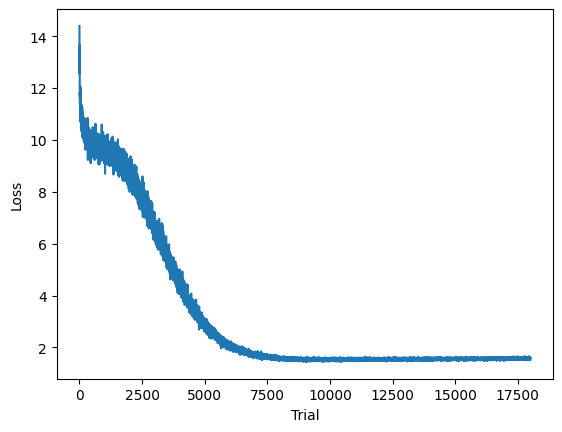

accuracy on test dataset :  0.4372


In [ ]:
# evaluation on test dataset

preds = model(X_test) # (10000,)

print("accuracy on test dataset : ", np.mean(preds==y_test))